# Simulate impedance data from equivalent circuit models

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import sys
import os
from impedance.models.circuits import CustomCircuit
import pandas as pd
from scipy.integrate import quad

if '../bayes-drt' not in sys.path:
    sys.path.append('../bayes-drt')
import eis_utils as gt
from stan_models import save_pickle,load_pickle
import drt

%load_ext autoreload
%autoreload 2

In [3]:
# Functions for adding artificial noise

def add_simple_noise(Z,seed,scale,kind='proportional'):
    randstate = np.random.RandomState(seed)
    rands = randstate.normal(loc=0,size=(len(Z),2),scale=scale)
    Z = np.copy(Z)    
    if kind=='proportional':
        sigma_r = Z.real*scale
        sigma_i = Z.imag*scale
        Z += rands[:,0]*Z.real + rands[:,1]*Z.imag*1j
    elif kind=='modulus':
        mod = ((Z*Z.conjugate())**0.5).real
        Z += rands[:,0]*mod + rands[:,1]*mod*1j
        sigma_r = mod*scale
        sigma_i = mod*scale
    elif kind=='uniform':
#         mod = ((Z*Z.conjugate())**0.5).real
#         std = np.std(mod)
#         Z_range = np.max(Z.real) - np.min(Z.real)
        Z += rands[:,0] + rands[:,1]*1j
        sigma_r = scale
        sigma_i = scale
    
    return Z,sigma_r,sigma_i

def add_model_noise(Z,seed,alpha,beta,model='Orazem'):
    "Add noise following Orazem or Macdonald's models"
    randstate = np.random.RandomState(seed)
    rands = randstate.normal(loc=0,size=(len(Z),2),scale=1)    
    Z = np.copy(Z)
    if model=='Orazem':
        # real and imaginary sigmas are equal and contain contributions from real and imaginary impedance magnitudes
        sigma = alpha*np.abs(Z.real) + beta*np.abs(Z.imag)
        Z += rands[:,0]*sigma + rands[:,1]*sigma*1j
        sigma_r = sigma
        sigma_i = sigma
    elif model=='Macdonald':
        # real and imaginary sigmas are distinct and include a uniform resolution contribution and a 
        # proportional contribution
#         Zmod = (Z*Z.conjugate()).real**0.5
        sigma_r = alpha + beta*np.abs(Z.real)
        sigma_i = alpha + beta*np.abs(Z.imag)
        Z += rands[:,0]*sigma_r + rands[:,1]*sigma_i*1j
    
    return Z,sigma_r,sigma_i

# functions for obtaining analytical DRTs from equivalent circuit elements
def zarc_drt(t,t0,n):
    "Analytical DRT of ZARC"
    return (1/(2*np.pi))*np.sin((1-n)*np.pi)/(np.cosh(n*np.log(t/t0))-np.cos((1-n)*np.pi))

def ger_drt(t,t0):
    "Analytical DRT of Gerischer"
    t = np.sort(t)
    tl = t[t<=t0]
    th = t[t>t0]
    out = np.zeros(len(t))
    out[:len(tl)] = (1/np.pi)*np.sqrt(tl/(t0-tl))
    out[len(tl):] = 0
    return out

def hn_drt(t,t0,nu,beta):
    theta = np.arctan(np.abs(np.sin(nu*np.pi)/((t/t0)**nu + np.cos(nu*np.pi))))
    g = (1/np.pi)*(t/t0)**(nu*beta)*np.sin(beta*theta)/((t/t0)**(2*nu) + 2*(t/t0)**nu*np.cos(nu*np.pi) + 1)**(beta/2)
    return g

def drt_from_ecm(params,tau,num_RC=None):
    """Get analytical DRT from equivalent circuit model parameters
    ECM must be a series of ZARCS with R_infty and inductance
    """
    if num_RC is None:
        num_RC = int((len(params) - 2)/3)
    gamma = np.zeros_like(tau)
    for n in range(num_RC):
        R = params[f'R{n}']
        Q = params[f'Q{n}']
        n = params[f'n{n}']
        tau_0 = (R*Q)**(1/n)
        gamma += R*zarc_drt(tau,tau_0,n)
    return gamma


# Synthetic spectra

In [3]:
freq = np.logspace(6,-2,81)
tau = 1/(2*np.pi*freq)
# finer tau for plotting
tau_plot = np.logspace(-7,2,200)
sim_path = '../data/simulated'

In [106]:
# define circuits
circ_rc = CustomCircuit(circuit='R0-p(R1,C1)',initial_guess=[1,1,1e-2])
circ_zarc = CustomCircuit(circuit='R0-p(R1,E1)',initial_guess=[1,1,1e-3**(0.8),0.8])
circ_ger = CustomCircuit(circuit='R0-G0',initial_guess=[1,1,1e-2])
circ_2rc = CustomCircuit(circuit='R0-p(R1,C1)-p(R2,C2)',initial_guess=[1,1,1e-2,1,1e-3])
circ_2zarc = CustomCircuit(circuit='R0-p(R1,E1)-p(R2,E2)',initial_guess=[1,1,1e-2**0.8,0.8, 1,1e-3**0.8,0.8])
circ_rl = CustomCircuit(circuit='R0-p(R1,E1)-p(R2,E2)',initial_guess=[1,1,1e-2**0.8,0.8, -0.2,-10,0.9])

circuits = [circ_rc,circ_zarc,circ_ger,circ_2rc,circ_2zarc,circ_rl]
circuit_labels = ['RC','ZARC','Gerischer','2RC','2ZARC','ZARC-RL']

# define analytical DRTs
# gamma_rc is delta function
gamma_zarc = zarc_drt(tau_plot,1e-3,0.8)
gamma_ger = ger_drt(tau_plot,1e-2)
# gamma_2rc is 2 delta functions
gamma_2zarc = zarc_drt(tau_plot,1e-2,0.8) + zarc_drt(tau_plot,1e-3,0.8)
gamma_rl = zarc_drt(tau_plot,1e-2,0.8) - 0.2*zarc_drt(tau_plot,(10*0.2)**(1/0.9),0.9)

gammas = [None,gamma_zarc,gamma_ger,None,gamma_2zarc,gamma_rl]

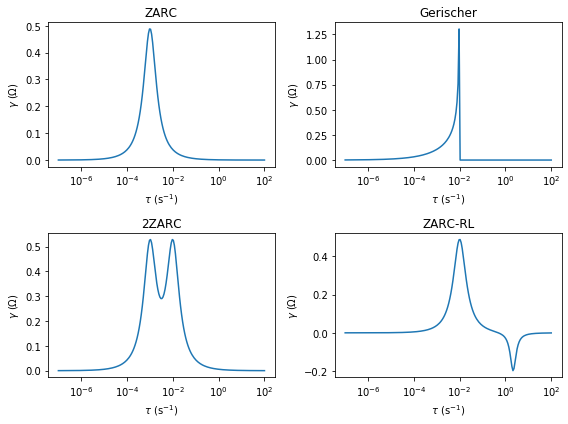

In [251]:
# plot and save analytical DRTs
fig,axes = plt.subplots(2,2,figsize=(8,6))

i = 0
for label,gamma in zip(circuit_labels,gammas):
    if gamma is not None:
        ax = axes.ravel()[i]
        ax.plot(tau_plot,gamma)
        ax.set_title(label)
        ax.set_xscale('log')
        ax.set_xlabel(r'$\tau$ (s$^{-1}$)')
        ax.set_ylabel('$\gamma$ ($\Omega$)')
        
        df = pd.DataFrame(np.array([tau_plot, gamma]).T,columns=['tau','gamma'])
        df.to_csv(os.path.join(sim_path,'gamma_{}.csv'.format(label)),index=False)
        i += 1
        
fig.tight_layout()

Simulating circuit based on initial parameters
0.0019240425371491675
0.007696170148596667
0.019240425371491655
0.002061488566536492
0.00824595426614595
0.020614885665364874
0.002116739902068842
0.008466959608275367
0.02116739902068843
Simulating circuit based on initial parameters
0.0019220705718076272
0.007688282287230483
0.01922070571807623
0.0018845575504606643
0.007538230201842673
0.018845575504606665
0.002191251602191271
0.008765006408765062
0.02191251602191267
Simulating circuit based on initial parameters
0.00193540108469462
0.007741604338778473
0.0193540108469462
0.0021982157090097917
0.00879286283603918
0.02198215709009798
0.0020574543705884846
0.008229817482353909
0.02057454370588478
Simulating circuit based on initial parameters
0.0037862695757117587
0.015145078302847042
0.037862695757117586
0.004053746041079881
0.016214984164319546
0.04053746041079886
0.0042148463797584655
0.016859385519033845
0.04214846379758461
Simulating circuit based on initial parameters
0.003897161951

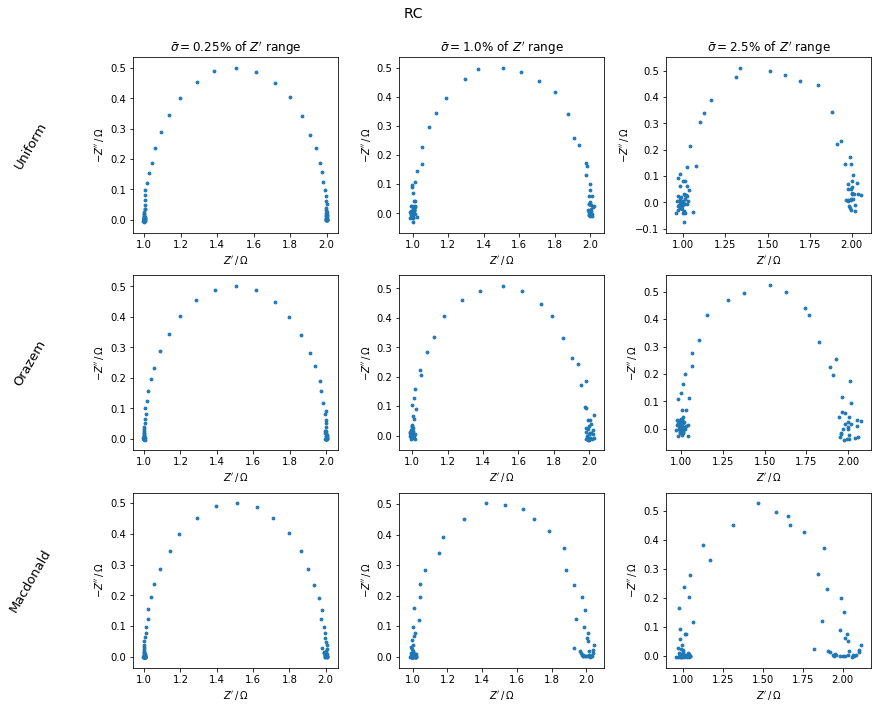

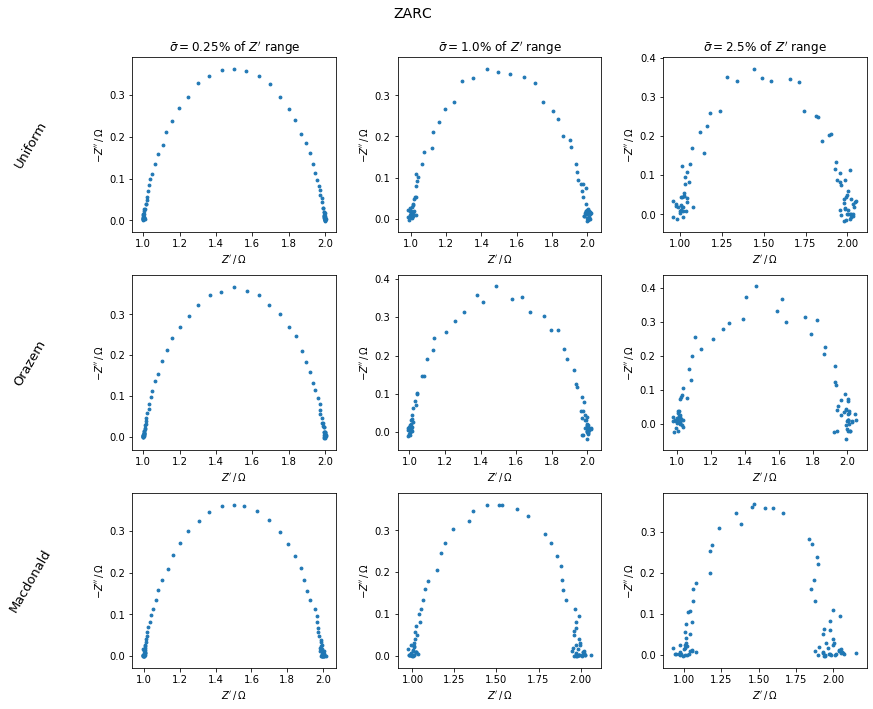

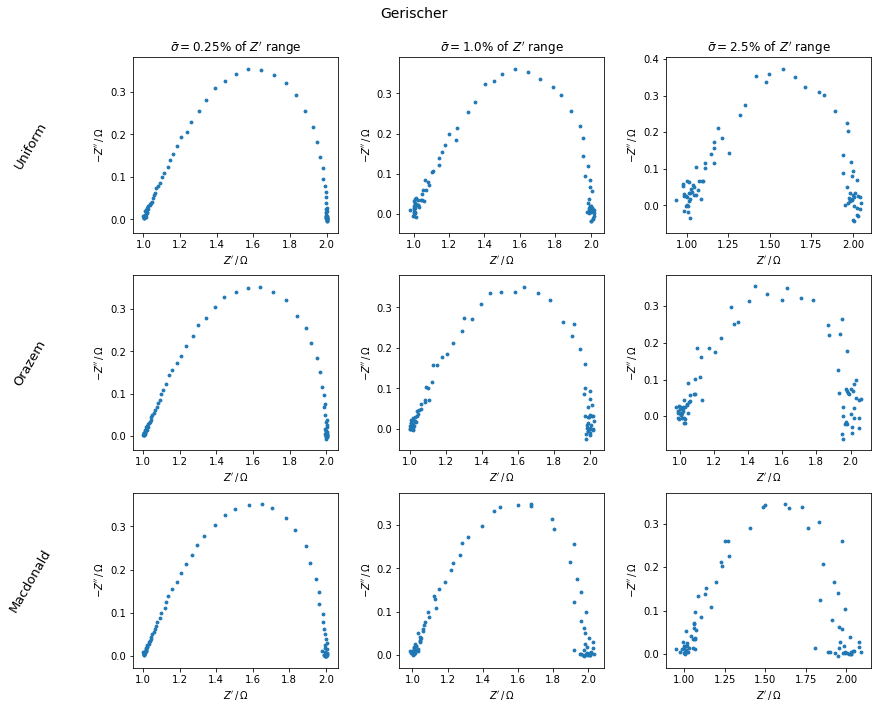

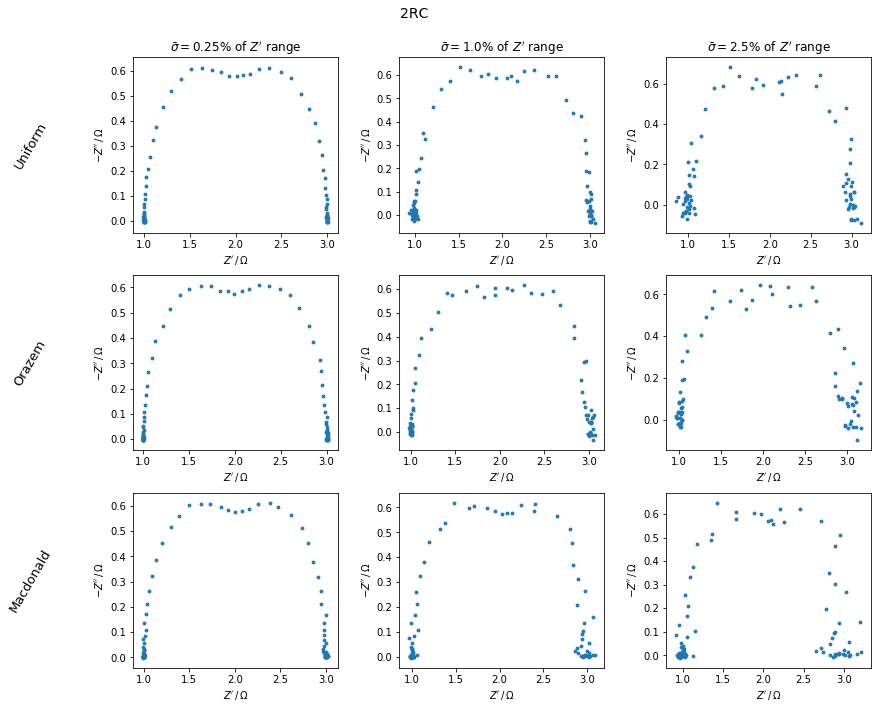

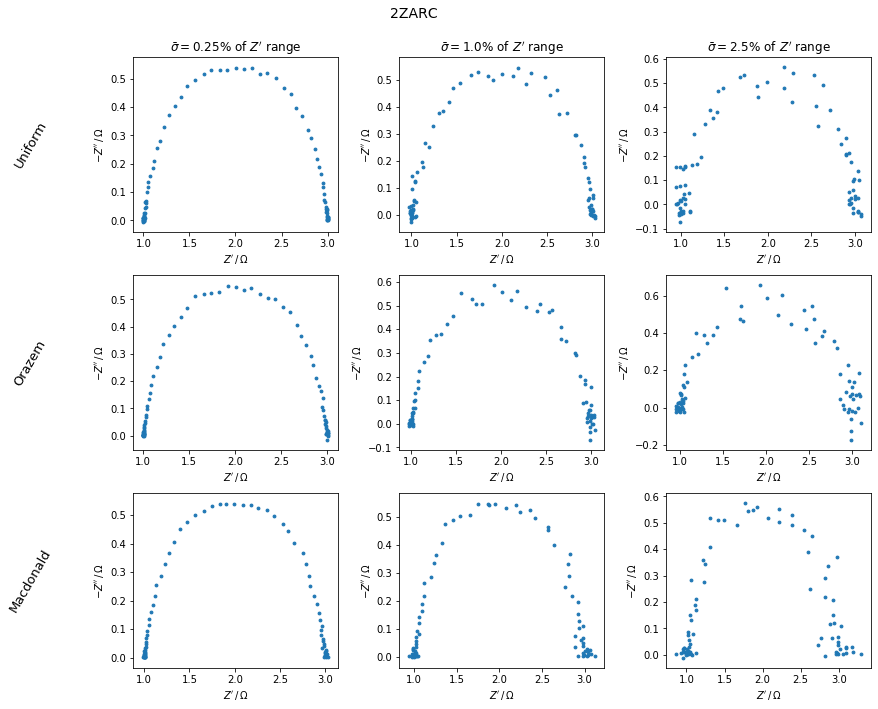

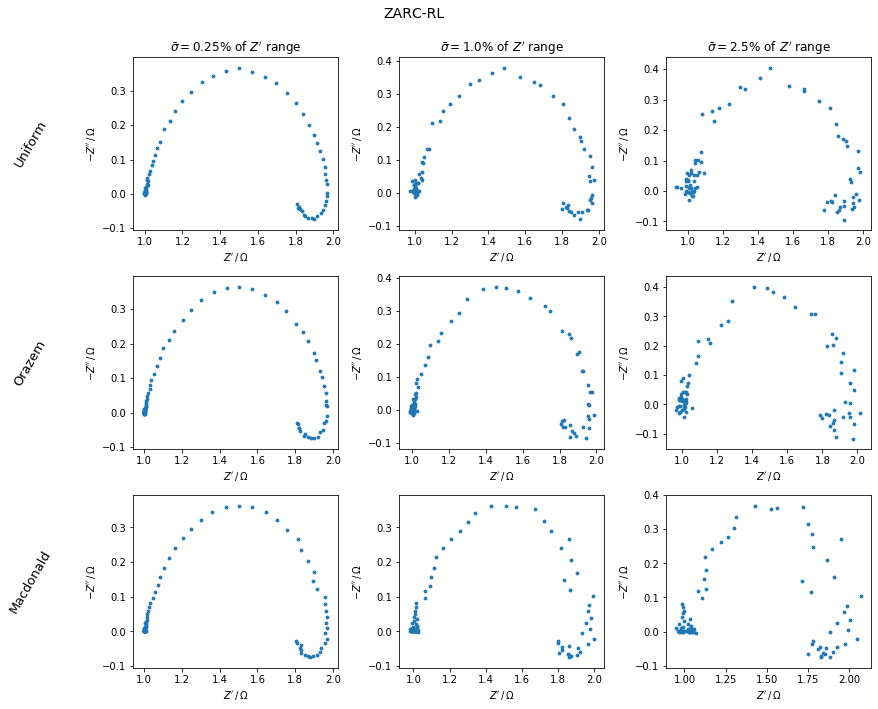

In [250]:
# Add artificial noise to exact impedance and save data files
rng = np.random.RandomState(seed=135348)

for circuit,label in zip(circuits,circuit_labels):
    Z = circuit.predict(freq)
    Z_range = np.max(Z.real) - np.min(Z.real)
    mean_zr = np.mean(np.abs(Z.real))
    mean_zi = np.mean(np.abs(Z.imag))

    mean_sigmas = [0.0025,0.01,0.025] # as fraction of Z_range

    fig,axes = plt.subplots(3,3,figsize=(13,10))
    
    # Save noiseless data
    df = gt.construct_eis_df(freq,Z)
    df.to_csv(os.path.join(sim_path,'Z_{}_noiseless.csv'.format(label)),index=False)

    # uniform noise
    # use the same seed for each noise level, but use different seeds for different circuits and different error structures
    unif_seed = rng.randint(1e5)
    for i,mean_sigma in enumerate(mean_sigmas):
        Zn,sigma_r,sigma_i = add_simple_noise(Z,unif_seed,mean_sigma*Z_range,'uniform')
        # check average deviation
        print((np.mean(np.abs((Zn-Z).real)) + np.mean(np.abs((Zn-Z).imag)))/2)
        df = gt.construct_eis_df(freq,Zn)
        df['sigma_re'] = sigma_r
        df['sigma_im'] = sigma_i
        gt.plot_nyquist(df,ax=axes[0,i])
#         print(f'{label}_uniform_{mean_sigma}.csv')
        df.to_csv(os.path.join(sim_path,'Z_{}_uniform_{}.csv'.format(label,100*mean_sigma)),index=False)

    # Orazem model
    orazem_seed = rng.randint(1e5)
    for i,mean_sigma in enumerate(mean_sigmas):
        # set alpha_re = alpha_im
        alpha = mean_sigma*Z_range/(mean_zr+mean_zi)
        Zn,sigma_r,sigma_i = add_model_noise(Z,orazem_seed,alpha,alpha,'Orazem')
        # check average deviation
        print((np.mean(np.abs((Zn-Z).real)) + np.mean(np.abs((Zn-Z).imag)))/2)
        df = gt.construct_eis_df(freq,Zn)
        df['sigma_re'] = sigma_r
        df['sigma_im'] = sigma_i
        gt.plot_nyquist(df,ax=axes[1,i])
        df.to_csv(os.path.join(sim_path,'Z_{}_Orazem_{}.csv'.format(label,100*mean_sigma)),index=False)

    # Macdonald model
    macdonald_seed = rng.randint(1e5)
    for i,mean_sigma in enumerate(mean_sigmas):
        # set alpha = 0.1*mean_sigma, leave remainder to proportional error
        alpha = 0.1*mean_sigma*Z_range
        beta = mean_sigma*1.8*Z_range/(mean_zr+mean_zi)
        Zn,sigma_r,sigma_i = add_model_noise(Z,macdonald_seed,alpha,beta,'Macdonald')
        # check average deviation
        print((np.mean(np.abs((Zn-Z).real)) + np.mean(np.abs((Zn-Z).imag)))/2)
        df = gt.construct_eis_df(freq,Zn)
        df['sigma_re'] = sigma_r
        df['sigma_im'] = sigma_i
        gt.plot_nyquist(df,ax=axes[2,i])
        df.to_csv(os.path.join(sim_path,'Z_{}_Macdonald_{}.csv'.format(label,100*mean_sigma)),index=False)

    for ax,mean_sigma in zip(axes[0],mean_sigmas):
        ax.set_title(r'$\bar{{\sigma}}=${}% of $Z^\prime$ range'.format(100*mean_sigma))

    for ax, model in zip(axes[:,0],['Uniform','Orazem','Macdonald']):
        ax.text(-0.5,0.5,model,transform=ax.transAxes,rotation=60,size=13,ha='center',va='center')

    fig.tight_layout()
    fig.subplots_adjust(left=0.2,wspace=0.3,top=0.91)
    fig.suptitle(label,size=14)

## RC-ZARC circuit
Matching circuit from Effendy, Song, and Bazant (2020)

In [21]:
circ_rczarc = CustomCircuit(circuit='p(R1,C1)-p(R2,E2)',initial_guess=[1,np.exp(-2),1,np.exp(2*0.8),0.8])
omega_rcz = np.logspace(2,-2,41)
freq_rcz = omega_rcz/(2*np.pi)
tau_rcz = np.logspace(np.log10(np.exp(-5)),np.log10(np.exp(5.5)),200)

# continuous portion of DRT
gamma_rczarc = zarc_drt(tau_rcz,np.exp(2),0.8)
df = pd.DataFrame(np.array([tau_rcz, gamma_rczarc]).T,columns=['tau','gamma'])
df.to_csv(os.path.join(sim_path,'gamma_RC-ZARC.csv'),index=False)

Simulating circuit based on initial parameters
0.004047088529732765
0.016188354118931075
0.040470885297327674
0.0038789343356361496
0.015515737342544585
0.03878934335636147
0.004255472334809504
0.017021889339238004
0.04255472334809503


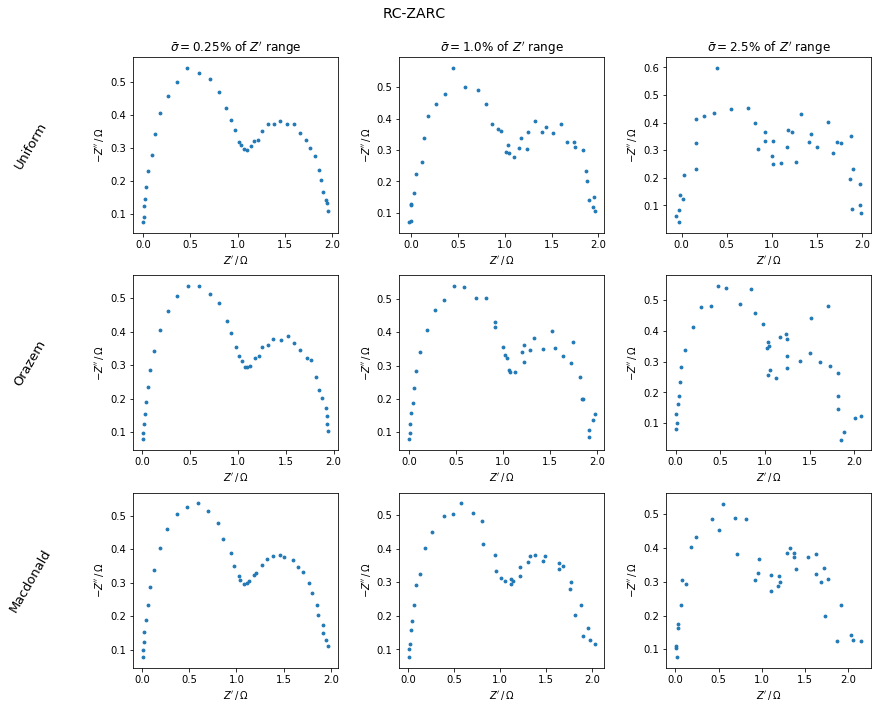

In [20]:
rng = np.random.RandomState(seed=89347)

label = 'RC-ZARC'

Z = circ_rczarc.predict(freq_rcz)
Z_range = np.max(Z.real) - np.min(Z.real)
mean_zr = np.mean(np.abs(Z.real))
mean_zi = np.mean(np.abs(Z.imag))

mean_sigmas = [0.0025,0.01,0.025] # as fraction of Z_range

fig,axes = plt.subplots(3,3,figsize=(13,10))

# Save noiseless data
df = gt.construct_eis_df(freq_rcz,Z)
df.to_csv(os.path.join(sim_path,'Z_{}_noiseless.csv'.format(label)),index=False)

# uniform noise
# use the same seed for each noise level, but use different seeds for different circuits and different error structures
unif_seed = rng.randint(1e5)
for i,mean_sigma in enumerate(mean_sigmas):
    Zn,sigma_r,sigma_i = add_simple_noise(Z,unif_seed,mean_sigma*Z_range,'uniform')
    # check average deviation
    print((np.mean(np.abs((Zn-Z).real)) + np.mean(np.abs((Zn-Z).imag)))/2)
    df = gt.construct_eis_df(freq_rcz,Zn)
    df['sigma_re'] = sigma_r
    df['sigma_im'] = sigma_i
    gt.plot_nyquist(df,ax=axes[0,i])
#         print(f'{label}_uniform_{mean_sigma}.csv')
    df.to_csv(os.path.join(sim_path,'Z_{}_uniform_{}.csv'.format(label,100*mean_sigma)),index=False)

# Orazem model
orazem_seed = rng.randint(1e5)
for i,mean_sigma in enumerate(mean_sigmas):
    # set alpha_re = alpha_im
    alpha = mean_sigma*Z_range/(mean_zr+mean_zi)
    Zn,sigma_r,sigma_i = add_model_noise(Z,orazem_seed,alpha,alpha,'Orazem')
    # check average deviation
    print((np.mean(np.abs((Zn-Z).real)) + np.mean(np.abs((Zn-Z).imag)))/2)
    df = gt.construct_eis_df(freq_rcz,Zn)
    df['sigma_re'] = sigma_r
    df['sigma_im'] = sigma_i
    gt.plot_nyquist(df,ax=axes[1,i])
    df.to_csv(os.path.join(sim_path,'Z_{}_Orazem_{}.csv'.format(label,100*mean_sigma)),index=False)

# Macdonald model
macdonald_seed = rng.randint(1e5)
for i,mean_sigma in enumerate(mean_sigmas):
    # set alpha = 0.1*mean_sigma, leave remainder to proportional error
    alpha = 0.1*mean_sigma*Z_range
    beta = mean_sigma*1.8*Z_range/(mean_zr+mean_zi)
    Zn,sigma_r,sigma_i = add_model_noise(Z,macdonald_seed,alpha,beta,'Macdonald')
    # check average deviation
    print((np.mean(np.abs((Zn-Z).real)) + np.mean(np.abs((Zn-Z).imag)))/2)
    df = gt.construct_eis_df(freq_rcz,Zn)
    df['sigma_re'] = sigma_r
    df['sigma_im'] = sigma_i
    gt.plot_nyquist(df,ax=axes[2,i])
    df.to_csv(os.path.join(sim_path,'Z_{}_Macdonald_{}.csv'.format(label,100*mean_sigma)),index=False)

for ax,mean_sigma in zip(axes[0],mean_sigmas):
    ax.set_title(r'$\bar{{\sigma}}=${}% of $Z^\prime$ range'.format(100*mean_sigma))

for ax, model in zip(axes[:,0],['Uniform','Orazem','Macdonald']):
    ax.text(-0.5,0.5,model,transform=ax.transAxes,rotation=60,size=13,ha='center',va='center')

    fig.tight_layout()
    fig.subplots_adjust(left=0.2,wspace=0.3,top=0.91)
    fig.suptitle(label,size=14)

## Truncated RL-ZARC-ZARC

Simulating circuit based on initial parameters
Simulating circuit based on initial parameters


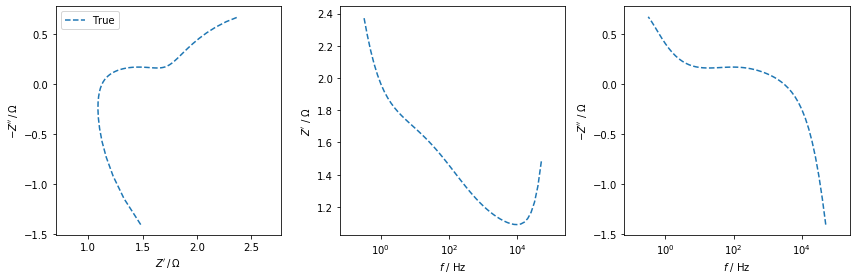

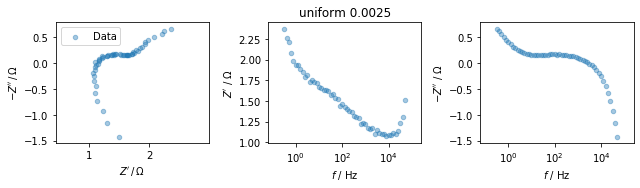

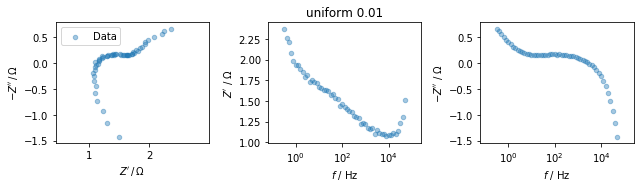

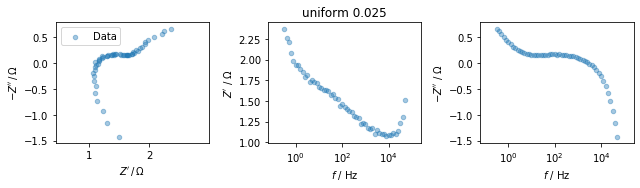

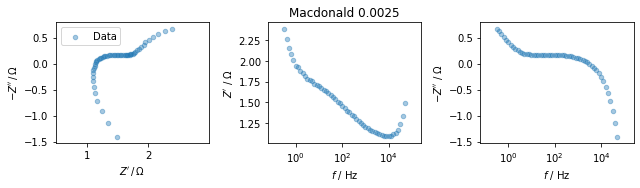

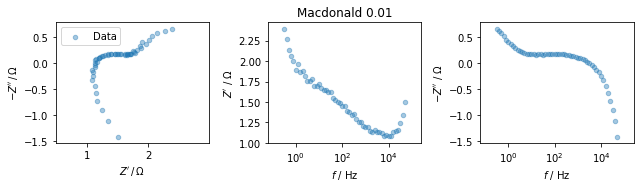

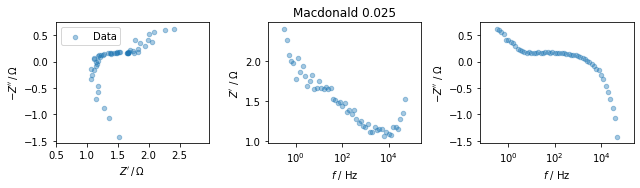

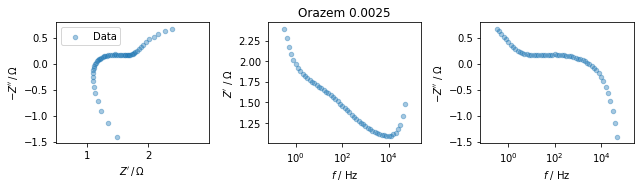

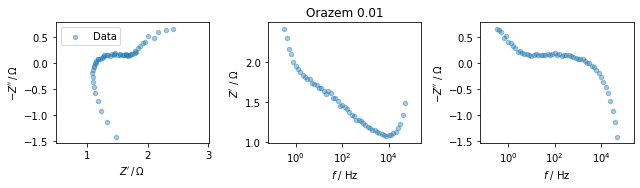

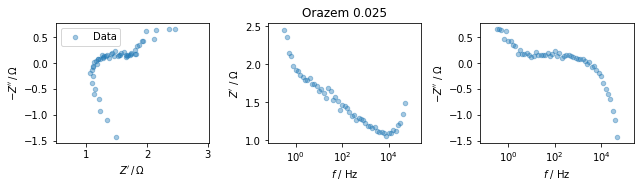

In [62]:
# define circuit
t1 = 1e-3
t2 = 1
R1 = 0.8
R2 = 2
n1 = 0.5
n2 = 0.8
Q1 = (t1**n1)/R1
Q2 = (t2**n2)/R2

tL = 1e-6
L = 5e-6
RL = L/tL

circ_2rqt = CustomCircuit(circuit='R0-p(R1,E1)-p(R2,E2)-p(R3,L3)',
                          initial_guess=[1, R1,Q1,n1, R2,Q2,n2, RL,L])

# truncated frequency range
freqt = np.logspace(4.7,-0.5,53)

# noiseless data
label = 'trunc'
Z = circ_2rqt.predict(freqt)
df = gt.construct_eis_df(freqt,Z)
# plot true impedance
fig,axes = plt.subplots(1,3,figsize=(12,4))
gt.plot_full_eis(df,axes=axes,bode_cols=['Zreal','Zimag'],plot_func='plot',label='True',ls='--')
# save noiseless data
df.to_csv(os.path.join(sim_path,'Z_{}_noiseless.csv'.format(label)),index=False)

# save full freq range impedance
freqf = np.logspace(6,-3,91)
Z_full = circ_2rqt.predict(freqf)
df_full = gt.construct_eis_df(freqf,Z_full)
df_full.to_csv(os.path.join(sim_path,'Z_{}_noiseless_FullRange.csv'.format(label)),index=False)

# add noise
rng = np.random.RandomState(seed=437895)
for err_model in ['uniform','Macdonald','Orazem']:
    seed = rng.randint(1e5)
    for mean_sigma in [0.0025,0.01,0.025]:
        # set noise params
        Z_range = np.max(Z.real) - np.min(Z.real)
        mean_zr = np.mean(np.abs(Z.real))
        mean_zi = np.mean(np.abs(Z.imag))
        alpha = 0.1*mean_sigma*Z_range
        beta = mean_sigma*1.8*Z_range/(mean_zr+mean_zi)
        if err_model=='Macdonald':
            Zn,sigma_r,sigma_i = add_model_noise(Z,seed,alpha,beta,err_model)
        elif err_model=='uniform':
            add_simple_noise(Z,seed,mean_sigma*Z_range,'uniform')
        elif err_model=='Orazem':
            alpha = mean_sigma*Z_range/(mean_zr+mean_zi)
            Zn,sigma_r,sigma_i = add_model_noise(Z,seed,alpha,alpha,err_model)
        ndf = gt.construct_eis_df(freqt,Zn)
        # plot noisy data
        axes = gt.plot_full_eis(ndf,bode_cols=['Zreal','Zimag'],label='Data',s=20,alpha=0.4)
        axes[1].set_title(f'{err_model} {mean_sigma}')
        # save noisy data
        ndf['sigma_re'] = sigma_r
        ndf['sigma_im'] = sigma_i
        ndf.to_csv(os.path.join(sim_path,'Z_{}_{}_{}.csv'.format(label,err_model,100*mean_sigma)),index=False)

# true DRT (except RL)
g_2rqt = R1*zarc_drt(tau_plot,t1,n1) + R2*zarc_drt(tau_plot,t2,n2)
gdf = pd.DataFrame(np.array([tau_plot, g_2rqt]).T,columns=['tau','gamma'])
gdf.to_csv(os.path.join(sim_path,'gamma_{}.csv'.format(label)),index=False)

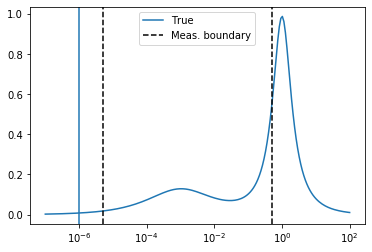

In [313]:
# plot true DRT
fig,ax = plt.subplots()
ax.plot(tau_plot,g_2rqt,label='True')
ax.axvline(tL)
ax.set_xscale('log')

ax.axvline(1/(2*np.pi*np.min(freqt)),ls='--',c='k',label='Meas. boundary')
ax.axvline(1/(2*np.pi*np.max(freqt)),ls='--',c='k')

ax.legend()

## Simulated DDT data

../bayes-drt\drt.py:2013: RuntimeWarning: overflow encountered in tanh
  omega = frequencies*2*np.pi


uniform 0.05: -5.878969339620924
Macdonald 0.05: -6.566250892246204
Orazem 0.05: -6.897549641060699
uniform 0.25: -4.2695314271868385
Macdonald 0.25: -4.956812979812106
Orazem 0.25: -5.2881117286265305


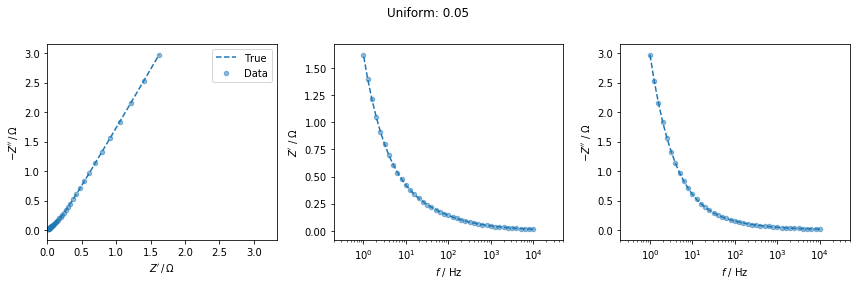

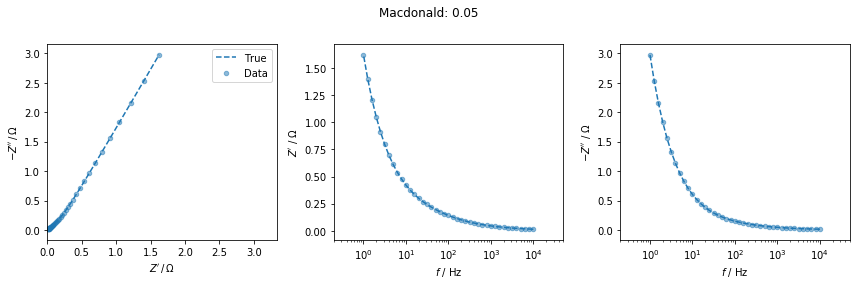

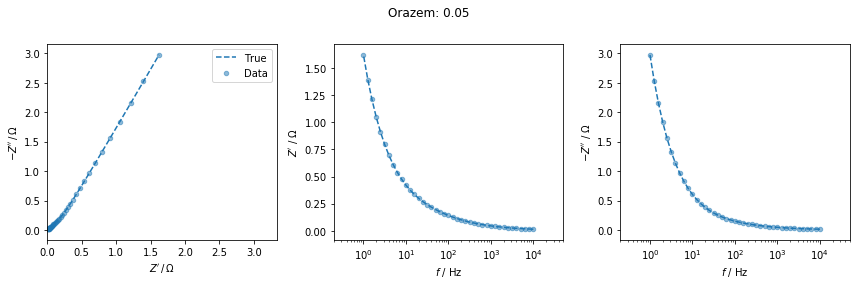

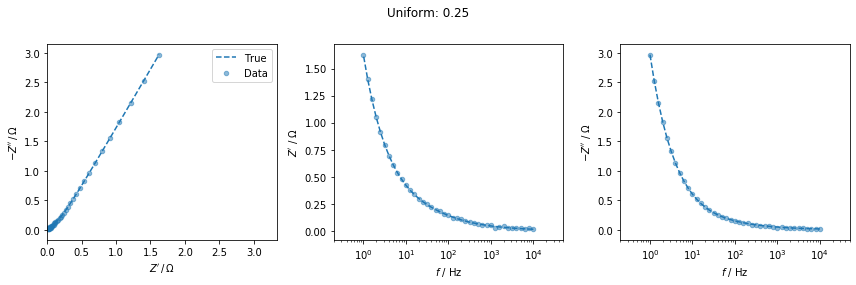

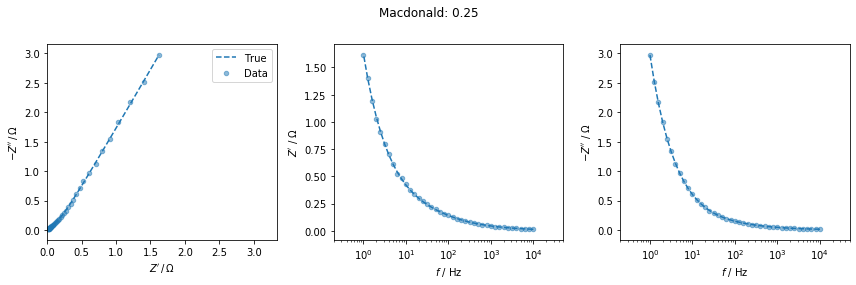

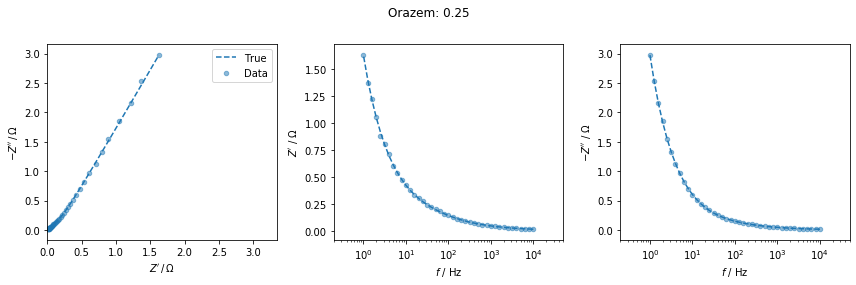

In [32]:
# Bimodal dispersed Cole-Cole, blocking planar
label = 'BimodalBP-DDT'

freq = np.logspace(4,0,41)
tau = 1/(2*np.pi*freq)
# finer tau for plotting
tau_plot = np.logspace(-7,2,200)

re_func = drt.get_A_func('real',basis='Cole-Cole',kernel='DDT',dist_type='parallel',
                      symmetry='planar',bc='blocking',ct=False)

im_func = drt.get_A_func('imag',basis='Cole-Cole',kernel='DDT',dist_type='parallel',
                      symmetry='planar',bc='blocking',ct=False)

phi = 0.7
omega = 2*np.pi*freq

t_0s = [1e-4,1e-2]
Yr_cc = np.zeros_like(freq)
Yi_cc = np.zeros_like(freq)
fd_true = np.zeros_like(tau_plot)
for t_0 in t_0s:
    Yr_cc += np.array([quad(re_func,-20,20,args=(w_n,t_0,phi),epsabs=1e-4)[0] for w_n in omega])
    Yi_cc += np.array([quad(im_func,-20,20,args=(w_n,t_0,phi),epsabs=1e-4)[0] for w_n in omega])
    fd_true += zarc_drt(tau_plot,t_0,phi)
    
Y_cc = Yr_cc + 1j*Yi_cc
Z = 1/Y_cc

# save true distribution
fdf = pd.DataFrame(np.array([tau_plot, fd_true]).T,columns=['tau','gamma'])
fdf.to_csv(os.path.join(sim_path,'gamma_{}.csv'.format(label)),index=False)

# save noiseless data
df = gt.construct_eis_df(freq,Z)
df.to_csv(os.path.join(sim_path,'Z_{}_noiseless.csv'.format(label)),index=False)

for mean_sigma in [0.0005,0.0025]:
    # add uniform noise
    Z_range = np.max(Z.real) - np.min(Z.real)
    Znu,sigma_r,sigma_i = add_simple_noise(Z,8934,mean_sigma*Z_range,'uniform')
    dfu = gt.construct_eis_df(freq,Znu)
    dfu['sigma_re'] = sigma_r
    dfu['sigma_im'] = sigma_i
    dfu.to_csv(os.path.join(sim_path,'Z_{}_uniform_{}.csv'.format(label,100*mean_sigma)),index=False)
    err = Znu-Z
    print('uniform {}:'.format(mean_sigma*100),
          0.5*np.mean(np.log(np.abs(err.real/Z.real))) + 0.5*np.mean(np.log(np.abs(err.imag/Z.imag))))

    # add Macdonald noise
    mean_zr = np.mean(np.abs(Z.real))
    mean_zi = np.mean(np.abs(Z.imag))
    alpha = 0.1*mean_sigma*Z_range
    beta = mean_sigma*1.8*Z_range/(mean_zr+mean_zi)
    Znm,sigma_r,sigma_i = add_model_noise(Z,345,alpha,beta,'Macdonald')
    dfm = gt.construct_eis_df(freq,Znm)
    dfm['sigma_re'] = sigma_r
    dfm['sigma_im'] = sigma_i
    dfm.to_csv(os.path.join(sim_path,'Z_{}_Macdonald_{}.csv'.format(label,100*mean_sigma)),index=False)
    err = Znm-Z
    print('Macdonald {}:'.format(mean_sigma*100),
          0.5*np.mean(np.log(np.abs(err.real/Z.real))) + 0.5*np.mean(np.log(np.abs(err.imag/Z.imag))))

    
    # add Orazem noise
    alpha = mean_sigma*Z_range/(mean_zr+mean_zi)
    Zno,sigma_r,sigma_i = add_model_noise(Z,937010,alpha,alpha,'Orazem')
    dfo = gt.construct_eis_df(freq,Zno)
    dfo['sigma_re'] = sigma_r
    dfo['sigma_im'] = sigma_i
    dfo.to_csv(os.path.join(sim_path,'Z_{}_Orazem_{}.csv'.format(label,100*mean_sigma)),index=False)
    err = Zno-Z
    print('Orazem {}:'.format(mean_sigma*100),
          0.5*np.mean(np.log(np.abs(err.real/Z.real))) + 0.5*np.mean(np.log(np.abs(err.imag/Z.imag))))

    for err_model,dfn in zip(['Uniform','Macdonald','Orazem'],[dfu,dfm,dfo]):
        fig,axes = plt.subplots(1,3,figsize=(12,4))
        # plot true impedance
        gt.plot_full_eis(df,axes=axes,bode_cols=['Zreal','Zimag'],plot_func='plot',label='True',ls='--')
        # plot noisy data
        gt.plot_full_eis(dfn,axes=axes,bode_cols=['Zreal','Zimag'],label='Data',s=20,alpha=0.5)
        fig.suptitle('{}: {}'.format(err_model,100*mean_sigma))
        fig.subplots_adjust(top=0.85)
    #     axes[0].set_xlim(0,1)
    #     axes[0].set_ylim(0,1)

../bayes-drt\drt.py:2035: RuntimeWarning: overflow encountered in tanh
  elif np.sum(match)==0:


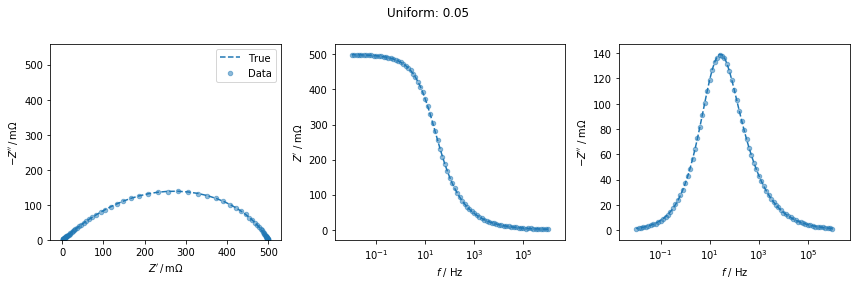

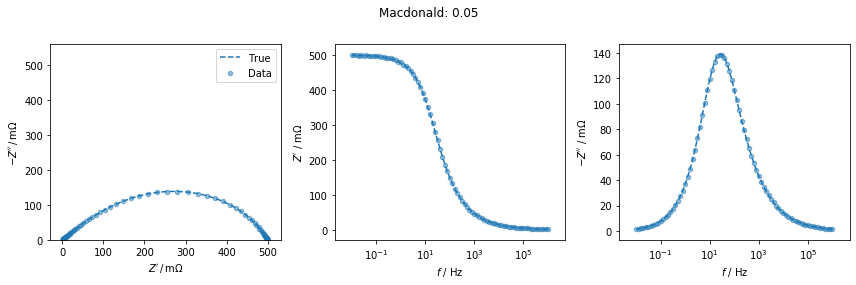

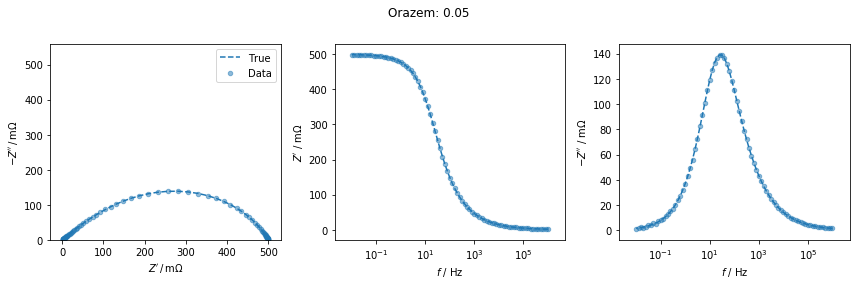

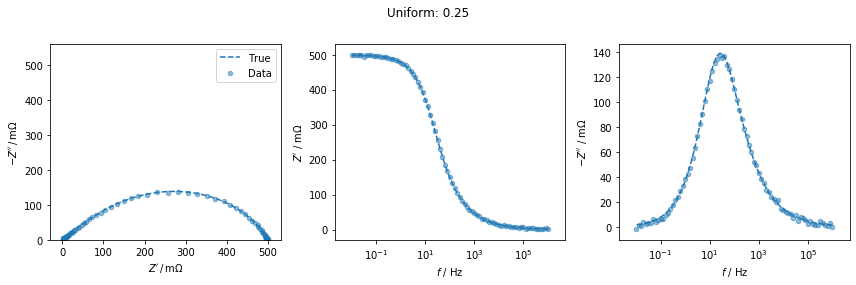

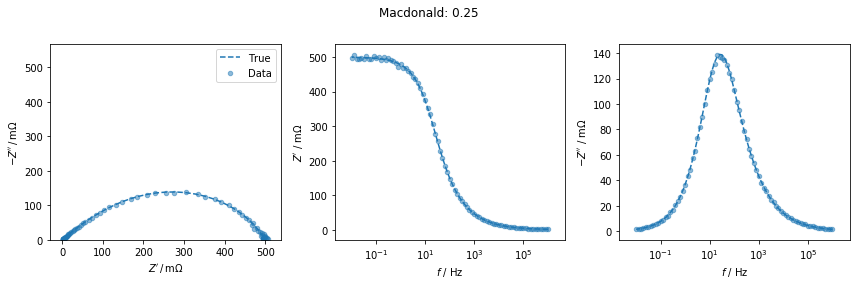

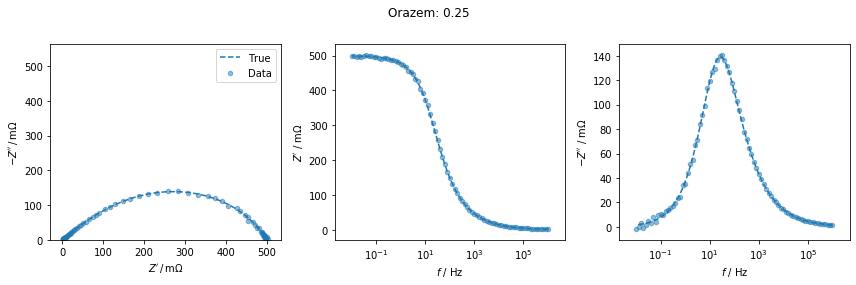

In [28]:
# Bimodal dispersed Cole-Cole, transmissive planar
label = 'BimodalTP-DDT'

freq = np.logspace(6,-2,81)
tau = 1/(2*np.pi*freq)
# finer tau for plotting
tau_plot = np.logspace(-7,2,200)

re_func = drt.get_A_func('real',basis='Cole-Cole',kernel='DDT',dist_type='parallel',
                      symmetry='planar',bc='transmissive',ct=False)

im_func = drt.get_A_func('imag',basis='Cole-Cole',kernel='DDT',dist_type='parallel',
                      symmetry='planar',bc='transmissive',ct=False)

phi = 0.7
omega = 2*np.pi*freq

t_0s = [1e-4,1e-2]
Yr_cc = np.zeros_like(freq)
Yi_cc = np.zeros_like(freq)
fd_true = np.zeros_like(tau_plot)
for t_0 in t_0s:
    Yr_cc += np.array([quad(re_func,-20,20,args=(w_n,t_0,phi),epsabs=1e-4)[0] for w_n in omega])
    Yi_cc += np.array([quad(im_func,-20,20,args=(w_n,t_0,phi),epsabs=1e-4)[0] for w_n in omega])
    fd_true += zarc_drt(tau_plot,t_0,phi)
    
Y_cc = Yr_cc + 1j*Yi_cc
Z = 1/Y_cc

# save true distribution
fdf = pd.DataFrame(np.array([tau_plot, fd_true]).T,columns=['tau','gamma'])
fdf.to_csv(os.path.join(sim_path,'gamma_{}.csv'.format(label)),index=False)

# save noiseless data
df = gt.construct_eis_df(freq,Z)
df.to_csv(os.path.join(sim_path,'Z_{}_noiseless.csv'.format(label)),index=False)

for mean_sigma in [0.0005,0.0025]:
    # add uniform noise
    Z_range = np.max(Z.real) - np.min(Z.real)
    Znu,sigma_r,sigma_i = add_simple_noise(Z,8934,mean_sigma*Z_range,'uniform')
    dfu = gt.construct_eis_df(freq,Znu)
    dfu['sigma_re'] = sigma_r
    dfu['sigma_im'] = sigma_i
    dfu.to_csv(os.path.join(sim_path,'Z_{}_uniform_{}.csv'.format(label,100*mean_sigma)),index=False)

    # add Macdonald noise
    mean_zr = np.mean(np.abs(Z.real))
    mean_zi = np.mean(np.abs(Z.imag))
    alpha = 0.1*mean_sigma*Z_range
    beta = mean_sigma*1.8*Z_range/(mean_zr+mean_zi)
    Znm,sigma_r,sigma_i = add_model_noise(Z,345,alpha,beta,'Macdonald')
    dfm = gt.construct_eis_df(freq,Znm)
    dfm['sigma_re'] = sigma_r
    dfm['sigma_im'] = sigma_i
    dfm.to_csv(os.path.join(sim_path,'Z_{}_Macdonald_{}.csv'.format(label,100*mean_sigma)),index=False)

    # add Orazem noise
    alpha = mean_sigma*Z_range/(mean_zr+mean_zi)
    Zno,sigma_r,sigma_i = add_model_noise(Z,937010,alpha,alpha,'Orazem')
    dfo = gt.construct_eis_df(freq,Zno)
    dfo['sigma_re'] = sigma_r
    dfo['sigma_im'] = sigma_i
    dfo.to_csv(os.path.join(sim_path,'Z_{}_Orazem_{}.csv'.format(label,100*mean_sigma)),index=False)

    for err_model,dfn in zip(['Uniform','Macdonald','Orazem'],[dfu,dfm,dfo]):
        fig,axes = plt.subplots(1,3,figsize=(12,4))
        # plot true impedance
        gt.plot_full_eis(df,axes=axes,bode_cols=['Zreal','Zimag'],plot_func='plot',label='True',ls='--')
        # plot noisy data
        gt.plot_full_eis(dfn,axes=axes,bode_cols=['Zreal','Zimag'],label='Data',s=20,alpha=0.5)
        fig.suptitle('{}: {}'.format(err_model,100*mean_sigma))
        fig.subplots_adjust(top=0.85)

# Mixed DRT and TP-DDT

Simulating circuit based on initial parameters
uniform 0.25: -5.200818352551238
Simulating circuit based on initial parameters
uniform 0.25: -4.964212415965099
Simulating circuit based on initial parameters
uniform 0.25: -4.723320165959873


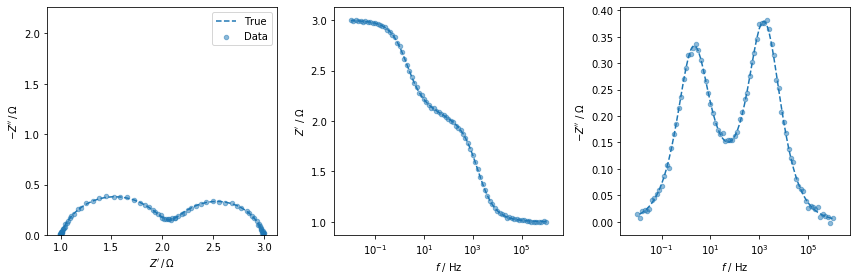

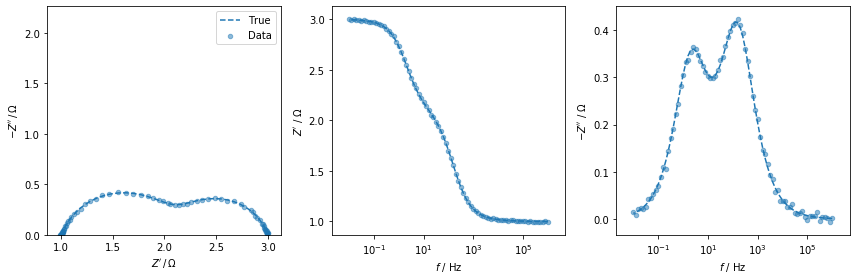

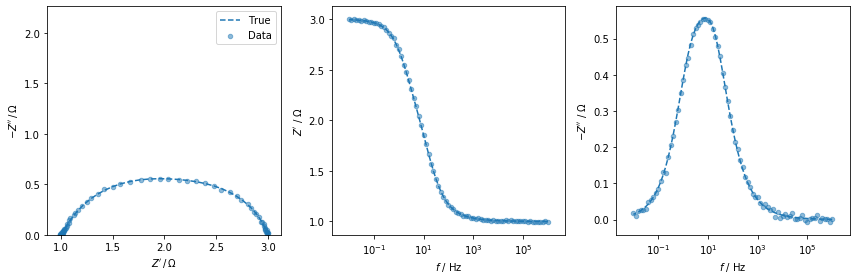

In [52]:
freq = np.logspace(6,-2,81)
omega = freq*2*np.pi
tau = 1/omega

# Generate TP-DDT impedance
re_func = drt.get_A_func('real',basis='Cole-Cole',kernel='DDT',dist_type='parallel',
                      symmetry='planar',bc='transmissive',ct=False)

im_func = drt.get_A_func('imag',basis='Cole-Cole',kernel='DDT',dist_type='parallel',
                      symmetry='planar',bc='transmissive',ct=False)

t_0 = 0.1
phi = 0.8
Yr_cc = np.array([quad(re_func,-20,20,args=(w_n,t_0,phi),epsabs=1e-4)[0] for w_n in omega])
Yi_cc = np.array([quad(im_func,-20,20,args=(w_n,t_0,phi),epsabs=1e-4)[0] for w_n in omega])
Y_cc = Yr_cc + 1j*Yi_cc
Zd_true = 1/Y_cc

fd_true = zarc_drt(tau_plot,t_0,phi)

for t_zarc in [1e-4,1e-3,1e-2]:
    # Generate ZARC impedance
    circ_drt = CustomCircuit(circuit='R0-p(R1,E1)',initial_guess=[1,1,t_zarc**(0.8),0.8])
    Z_drt = circ_drt.predict(freq)
    # true DRT
    g_true = zarc_drt(tau_plot,t_zarc,0.8)

    # add uniform noise
    Zc = Z_drt + Zd_true
    df = gt.construct_eis_df(freq,Zc)
    Z_range = np.max(Zc.real) - np.min(Zc.real)
    Znc,sigma_r,sigma_i = add_simple_noise(Zc,356,0.0025*Z_range,'uniform')
    dfn = gt.construct_eis_df(freq,Znc)
    dfn['sigma_re'] = sigma_r
    dfn['sigma_im'] = sigma_i
    err = Znc-Zc
    print('uniform {}:'.format(mean_sigma*100),
          0.5*np.mean(np.log(np.abs(err.real/Zc.real))) + 0.5*np.mean(np.log(np.abs(err.imag/Zc.imag))))
    
    # save noisy and noiseless data
    label = 'DRT{}-TpDDT'.format(int(np.log10(t_zarc)))
    df.to_csv(os.path.join(sim_path,f'Z_{label}_noiseless.csv'))
    dfn.to_csv(os.path.join(sim_path,f'Z_{label}_uniform_0.25.csv'))
    
    # save true distributions
    dist_df = pd.DataFrame(np.array([tau_plot, g_true, fd_true]).T,columns=['tau','gamma','ftp'])
    dist_df.to_csv(os.path.join(sim_path,f'gamma_{label}.csv'))
    
    # plot data
    fig,axes = plt.subplots(1,3,figsize=(12,4))
    gt.plot_full_eis(df,bode_cols=['Zreal','Zimag'],plot_func='plot',ls='--',label='True',axes=axes,unit_scale='')
    gt.plot_full_eis(dfn,bode_cols=['Zreal','Zimag'],label='Data',axes=axes,unit_scale='',alpha=0.5,s=20)

# Mixed DRT, TP-DDT, and BP-DDT

Simulating circuit based on initial parameters


../bayes-drt\drt.py:2051: RuntimeWarning: overflow encountered in tanh
  else:


mean rel err: -5.236301416442622


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001A9DF36F2C8>,
      dtype=object)

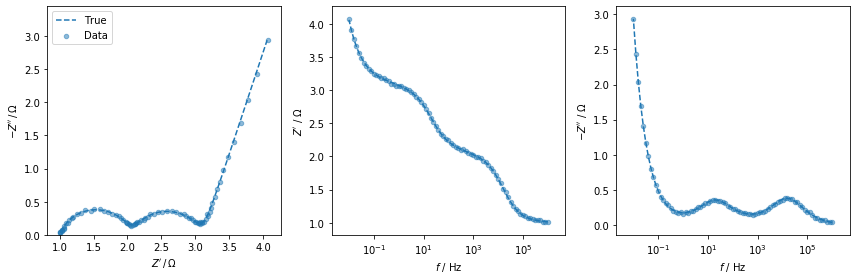

In [53]:
freq = np.logspace(6,-2,81)
omega = freq*2*np.pi
tau = 1/omega

# Generate ZARC impedance
circ_drt = CustomCircuit(circuit='R0-p(R1,E1)',initial_guess=[1,1,1e-5**(0.8),0.8])
Z_drt = circ_drt.predict(freq)
# true DRT
g_true = zarc_drt(tau_plot,1e-5,0.8)

# Generate TP-DDT impedance
tpre_func = drt.get_A_func('real',basis='Cole-Cole',kernel='DDT',dist_type='parallel',
                      symmetry='planar',bc='transmissive',ct=False)

tpim_func = drt.get_A_func('imag',basis='Cole-Cole',kernel='DDT',dist_type='parallel',
                      symmetry='planar',bc='transmissive',ct=False)

t_tp = 1e-2
phi = 0.8
Yr_tp = np.array([quad(tpre_func,-20,20,args=(w_n,t_tp,phi),epsabs=1e-4)[0] for w_n in omega])
Yi_tp = np.array([quad(tpim_func,-20,20,args=(w_n,t_tp,phi),epsabs=1e-4)[0] for w_n in omega])
Y_tp = Yr_tp + 1j*Yi_tp
Z_tp = 1/Y_tp
# true TP distribution
ftp_true = zarc_drt(tau_plot,t_tp,phi)

# Generate BP-DDT impedance
bpre_func = drt.get_A_func('real',basis='Cole-Cole',kernel='DDT',dist_type='parallel',
                      symmetry='planar',bc='blocking',ct=False)

bpim_func = drt.get_A_func('imag',basis='Cole-Cole',kernel='DDT',dist_type='parallel',
                      symmetry='planar',bc='blocking',ct=False)

t_bp = 1
phi = 0.8
Yr_bp = np.array([quad(bpre_func,-20,20,args=(w_n,t_bp,phi),epsabs=1e-4)[0] for w_n in omega])
Yi_bp = np.array([quad(bpim_func,-20,20,args=(w_n,t_bp,phi),epsabs=1e-4)[0] for w_n in omega])
Y_bp = 2*(Yr_bp + 1j*Yi_bp)
Z_bp = 1/Y_bp
# true BP distribution
fbp_true = 2*zarc_drt(tau_plot,t_bp,phi)

# add uniform noise
Zc = Z_drt + Z_tp + Z_bp
df = gt.construct_eis_df(freq,Zc)
Z_range = np.max(Zc.real) - np.min(Zc.real)
Znc,sigma_r,sigma_i = add_simple_noise(Zc,2383,0.0025*Z_range,'uniform')
dfn = gt.construct_eis_df(freq,Znc)
dfn['sigma_re'] = sigma_r
dfn['sigma_im'] = sigma_i
err = Znc-Zc
print('mean rel err:',
      0.5*np.mean(np.log(np.abs(err.real/Zc.real))) + 0.5*np.mean(np.log(np.abs(err.imag/Zc.imag))))

# save noisy and noiseless data
label = 'DRT-TpDDT-BpDDT'
df.to_csv(os.path.join(sim_path,f'Z_{label}_noiseless.csv'))
dfn.to_csv(os.path.join(sim_path,f'Z_{label}_uniform_0.25.csv'))

# save true distributions
dist_df = pd.DataFrame(np.array([tau_plot, g_true, ftp_true,fbp_true]).T,columns=['tau','gamma','ftp','fbp'])
dist_df.to_csv(os.path.join(sim_path,f'gamma_{label}.csv'))

# plot data
fig,axes = plt.subplots(1,3,figsize=(12,4))
gt.plot_full_eis(df,bode_cols=['Zreal','Zimag'],plot_func='plot',ls='--',label='True',axes=axes,unit_scale='')
gt.plot_full_eis(dfn,bode_cols=['Zreal','Zimag'],label='Data',axes=axes,unit_scale='',alpha=0.5,s=20)

# Experimental data
## LIB data from DRTtools

There were several sample data files included in a folder named `import file samples` in a previous release of DRTtools. The current version available on Github (https://github.com/ciuccislab/DRTtools) does not appear to include these files. The file we selected was collected from a commercial lithium-ion battery.

In [57]:
# load LIB data
file = '../data/experimental/DRTtools_LIB_data.txt'
lib_df = pd.read_csv(file,sep='\t',header=None)
lib_df = pd.DataFrame(lib_df.values,columns=['Freq','Zreal','Zimag'])
Z_lib = (lib_df['Zreal'] + 1j*lib_df['Zimag']).values

# generate file with 1/4 of points (5 ppd)
f_qtr = lib_df['Freq'].values[::4]
Z_qtr = Z_lib[::4]
qtr_df = gt.construct_eis_df(f_qtr,Z_qtr)
qtr_df.to_csv('../data/experimental/DRTtools_LIB_data_qtr.csv',index=False)

Initial parameters: {'HFR': 0.11330933688784015, 'Lstray': 1e-06, 'R0': 0.1, 'Q0': 0.001, 'n0': 0.5}
Initial peak frequencies: [15915494.309189534]
1 RC element(s): Best result 4.30e-04 achieved within 4 restarts
New RQ element: peak frequency 6.30e-03, params {'R1': 0.041995882671944984, 'Q1': 228.42562995644008, 'n1': 0.7}
2 RC element(s): Best result 1.03e-04 achieved within 5 restarts
New RQ element: peak frequency 4.47e+02, params {'R2': 0.0005324175626312964, 'Q2': 7.242733446048783, 'n2': 0.7}


../bayes-drt\eis_utils.py:3187: RuntimeWarning: overflow encountered in double_scalars
  return (1/(2*np.pi))*1/(R*Q)**(1/n)
../bayes-drt\eis_utils.py:2489: RuntimeWarning: divide by zero encountered in log
  below_freq = np.array([np.log(frequency_bounds[0]) - np.log(min(f,frequency_bounds[0])) for f in f_peaks])


3 RC element(s): Best result 7.15e-07 achieved within 5 restarts
Could not achieve target objective function with 3 RC elements, but satisfied min_gain


C:\Users\jdh10\anaconda3\envs\stan\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001A9D8ACF648>,
      dtype=object)

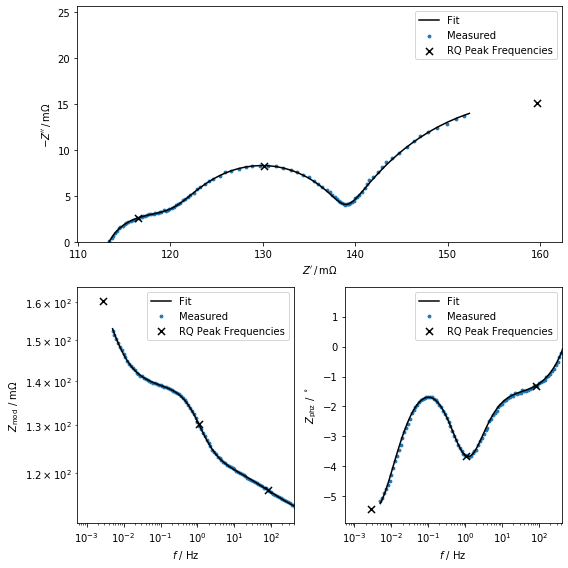

In [58]:
# fit equivalent circuit model to LIB data
tdf = gt.construct_eis_df(lib_df['Freq'],Z_lib)
lib_params, lib_hist = gt.fit_var_RC(tdf,0,1e-10,min_geo_gain=2,min_ari_gain=0.001,max_num_RC=3,
                                  early_stop=False,return_history=True,random_seed=11,
                                 frequency_bounds=(1e-6,1e3),simplex_params={'shift_factor':5})

# plot ECM fit
gt.plot_fit(tdf,lib_params,model=gt.Z_var_num_RC,mark_peaks=True)

In [200]:
# get analytical DRT from ECM
tau_lib = 1/(2*np.pi*np.logspace(4,-5,200))
g_lib = drt_from_ecm(lib_params,tau_lib)
Gres = pd.DataFrame(np.array([tau_lib,g_lib]).T,columns=['tau','gamma'])
# save DRT to file
Gres.to_csv('../data/experimental/gamma_LIB_ECM.csv',index=False)
# save ECM fit parameters
save_pickle(lib_params,'../data/experimental/EcmParams_LIB.pkl')
# save ECM impedance fit
Z_ecm = gt.Z_var_num_RC(lib_df['Freq'].values,**lib_params)
df_ecm = gt.construct_eis_df(lib_df['Freq'].values,Z_ecm)
df_ecm.to_csv('../data/experimental/Z_ECM_LIB.csv')

Dumped pickle to ../data/experimental/EcmParams_LIB.pkl


## Protonic ceramic microelectrode
This data was collected in a high-throughput measurement of a thin film microelectrode array.

Initial parameters: {'HFR': 0, 'Y': 8.333333333333334e-08, 't0': 5, 'R0': 4200000.0, 'Q0': 4.0370022891369415e-10, 'n0': 0.85}
Initial peak frequencies: [289.37262380344606]
1 RC element(s): Best result 3.56e+09 achieved within 1 restarts
New RQ element: peak frequency 3.97e+01, params {'R1': 3237263.4604820437, 'Q1': 6.482679142032727e-09, 'n1': 0.7}
2 RC element(s): Best result 1.06e+09 achieved within 2 restarts
Could not achieve target objective function with 2 RC elements, but satisfied min_gain


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002290C612808>,
      dtype=object)

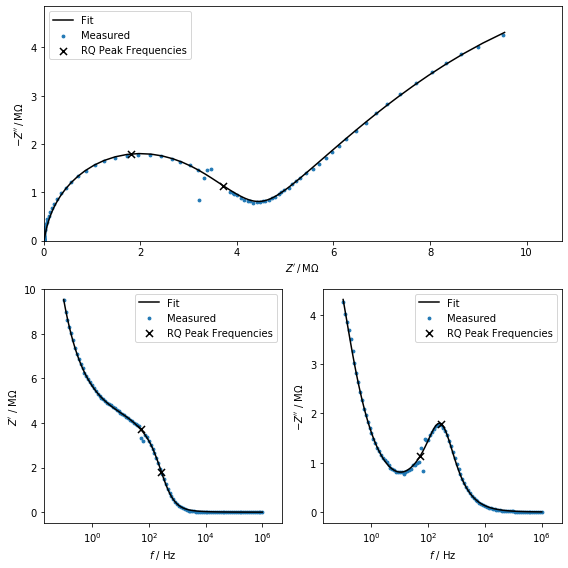

In [52]:
# file from: spectra_20200409\PDAC_COM3_02109_16pts_5x_R1_dryair_500C_2
tco_file = '../data/experimental/PDAC_COM3_02109_Contact10_2065C_500C.txt'
tco_df = gt.read_eis_zdata(tco_file)

# fit ECM with Gerischer and ZARCs to data
def Z_varRQ_ger(w,HFR,Y,t0,**RC_params):
    """
    Impedance of circuit with 1-n parallel RQ circuits in series with a resistor (HFR) and Gerischer element (Y, t0)
    Args:
        w: frequency (Hz)
        HFR: high-frequency resistance
        Y: admittance of Gerischer element
        t0: characteristic time constant of Gerischer element
        RC_params: parameters for each parallel RQ circuit. keys: R, Q, n
    """
    num_RC = int(len(RC_params)/3)

    Z_RC = [gt.Z_par(gt.Z_cpe(w,RC_params[f'Q{i}'],RC_params[f'n{i}']), RC_params[f'R{i}']) for i in range(num_RC)]

    return gt.Z_ger(w,Y,t0) + HFR + np.sum(Z_RC,axis=0)

# remove corrupted data points before fitting
cdf = tco_df[~tco_df.index.isin([61,62,63,64])]

# estimate initial parameters from DRT
init_params = {'R0':4.2e6,'Q0':0.55e-3**0.85/4.2e6,'n0':0.85,'Y':1/1.2e7,'t0':5,'HFR':0}

tcog_params,tcog_hist = gt.fit_var_RC(cdf,0,1e-10,min_geo_gain=2,min_ari_gain=0.001,max_num_RC=2,
                                    model = Z_varRQ_ger,init_params=init_params,est_HFR=False,
                                  early_stop=False,return_history=True,random_seed=11,weighting='unity',
                                 frequency_bounds=None,simplex_params={'shift_factor':5})
# plot ECM fit
gt.plot_fit(tco_df,tcog_params,model=Z_varRQ_ger,mark_peaks=True,bode_cols=['Zreal','Zimag'])

Initial parameters: {'HFR': 1, 'R0': 1000000.0, 'Q0': 0.001, 'n0': 0.5}
Initial peak frequencies: [1.5915494309189535e-07]
1 RC element(s): Best result 6.99e+11 achieved within 1 restarts
New RQ element: peak frequency 4.64e+01, params {'R1': 3289140.6783565427, 'Q1': 5.722129937889218e-09, 'n1': 0.7}
2 RC element(s): Best result 2.95e+09 achieved within 3 restarts
New RQ element: peak frequency 1.36e-01, params {'R2': 12595042.547885155, 'Q2': 8.865690840229919e-08, 'n2': 0.7}
3 RC element(s): Best result 8.89e+08 achieved within 1 restarts
Could not achieve target objective function with 3 RC elements, but satisfied min_gain


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001A9DCB91948>,
      dtype=object)

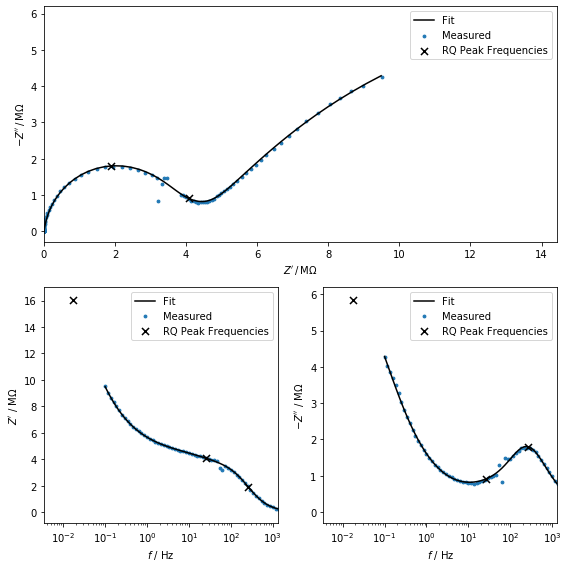

In [60]:
# fit ECM with only ZARCs to data
tco_params,tco_hist = gt.fit_var_RC(cdf,0,1e-10,min_geo_gain=2,min_ari_gain=0.001,max_num_RC=3,
                                    model=gt.Z_var_num_RC_noL,est_HFR=False,
                                  early_stop=False,return_history=True,random_seed=11,weighting='unity',
                                 frequency_bounds=None,simplex_params={'shift_factor':5})
# plot ECM fit
gt.plot_fit(tco_df,tco_params,model=gt.Z_var_num_RC_noL,mark_peaks=True,bode_cols=['Zreal','Zimag'])

In [61]:
tau_tco = np.logspace(-7,4,200)
# get analytical DRT from ECM
# with Gerischer
g_tcog = drt_from_ecm(tcog_params,tau_tco,2)
g_tcog += (1/tcog_params['Y'])*ger_drt(tau_tco,tcog_params['t0'])
Gresg = pd.DataFrame(np.array([tau_tco,g_tcog]).T,columns=['tau','gamma'])
# without Gerischer
g_tco = drt_from_ecm(tco_params,tau_tco,3)
Gres = pd.DataFrame(np.array([tau_tco,g_tco]).T,columns=['tau','gamma'])
# save DRTs to files
Gresg.to_csv('../data/experimental/gamma_PDAC_ECM-ger.csv',index=False)
Gres.to_csv('../data/experimental/gamma_PDAC_ECM.csv',index=False)
# save ECM fit parameters
save_pickle(tcog_params,'../data/experimental/EcmParams_PDAC-ger.pkl')
save_pickle(tco_params,'../data/experimental/EcmParams_PDAC.pkl')
# save ECM impedance fit (with Gerischer)
Z_ecmg = Z_varRQ_ger(tco_df['Freq'].values,**tcog_params)
df_ecmg = gt.construct_eis_df(tco_df['Freq'].values,Z_ecmg)
df_ecmg.to_csv('../data/experimental/Z_ECM-ger_PDAC.csv')
# save ECM impedance fit (without Gerischer)
Z_ecm = gt.Z_var_num_RC_noL(tco_df['Freq'].values,**tco_params)
df_ecm = gt.construct_eis_df(tco_df['Freq'].values,Z_ecm)
df_ecm.to_csv('../data/experimental/Z_ECM_PDAC.csv')

Dumped pickle to ../data/experimental/EcmParams_PDAC-ger.pkl
Dumped pickle to ../data/experimental/EcmParams_PDAC.pkl
